## **UNIVERSIDADE FEDERAL DE ALAGOAS**
### INSTITUTO DE COMPUTAÇÃO
### Engenharia de Computação
### Professor Ícaro Araujo
</br>

### **SISTEMAS DE CONTROLE 2**
</br>

#### **Bruno Lemos de Lima**
#### **Karla Sophia Santana da Cruz**
#### **Leticia Gabriela Cena de Lima** 
#### **Maria Fernanda Herculano Machado da Silva**


In [ ]:
!pip install control

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 398 kB 7.9 MB/s 
  Created wheel for control: filename=control-0.9.2-py2.py3-none-any.whl size=403205 sha256=2423ff3cd38439cada7da60ae32909dd5813df7b78adfc3b1a1046b2bb24d709
  Stored in directory: /root/.cache/pip/wheels/a6/3d/b3/8c508e66f4d44cf71b9ec49b94d4a074c8f2ee52475cd8920e
Successfully built control


In [ ]:
import control
from scipy import signal
import matplotlib.pyplot as plt
from control import matlab
import numpy as np

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Como foi descrito no relatório de modelagem de sistemas físicos, o sistema em estudo apresenta a seguinte função de transferência $G(s)$ em malha aberta.

$G(s) = \displaystyle \frac{3.75 s + 2.5}{s^4 + 7.875 s^3 + 15.25 s^2 + 3.75 s + 2.5}$

In [ ]:
num = [0,0,0,3.75,2.5]
den = [1, 7.875, 15.25, 3.75, 2.5]

sys_continuo = signal.TransferFunction(num,den)

# 1. Discretize o sistema utilizando as seguintes aproximações:

## a. Euler com $T_s$ = 0,1

In [ ]:
sys_discreto_euler = signal.cont2discrete((num,den), 0.1, 'euler')

num_euler = sys_discreto_euler[0][0]
den_euler = sys_discreto_euler[1]

print("Função de transferência discretizado pelo método de Euler:\n",control.TransferFunction(num_euler, den_euler))

Função de transferência discretizado pelo método de Euler:
 
-3.109e-15 s^3 + 6.661e-15 s^2 + 0.00375 s - 0.0035
---------------------------------------------------
   s^4 - 3.212 s^3 + 3.79 s^2 - 1.939 s + 0.3615



## b. Backward com $T_s$ = 0,1

In [ ]:
sys_discreto_backward = signal.cont2discrete((num,den), 0.1, 'backward_diff')

num_backward = sys_discreto_backward[0][0]
den_backward = sys_discreto_backward[1]

print("Função de transferência discretizado pelo método Backward:\n",control.TransferFunction(num_backward, den_backward))

Função de transferência discretizado pelo método Backward:
 
0.002058 s^4 - 0.001929 s^3 + 1.332e-14 s^2 - 1.11e-14 s + 2.998e-15
--------------------------------------------------------------------
           s^4 - 3.432 s^3 + 4.38 s^2 - 2.463 s + 0.5144



## c. Tustin com $T_s$ = 0,1

In [ ]:
sys_discreto_tustin = signal.cont2discrete((num,den), 0.1, 'bilinear')

num_tustin = sys_discreto_tustin[0][0]
den_tustin = sys_discreto_tustin[1]

print("Função de transferência discretizado pelo método de Tustin:\n",control.TransferFunction(num_tustin, den_tustin))

Função de transferência discretizado pelo método de Tustin:
 
0.0003382 s^4 + 0.0006981 s^3 + 6.545e-05 s^2 - 0.0006109 s - 0.0003163
-----------------------------------------------------------------------
            s^4 - 3.342 s^3 + 4.136 s^2 - 2.243 s + 0.4496



# 2. Utilizando o método de Tustin, teste diferentes valores de taxa de amostragem $T_s$ e comente sobre os efeitos dessa variação.

In [ ]:
taxas_de_amostragem = np.arange(0.1, 1.2, 0.2)
taxas_de_amostragem

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1])

In [ ]:
t = np.arange(0,50,0.1)
u = np.full(len(t),1) # entrada do tipo degrau

In [ ]:
tf_list_tustin = []

for tx in taxas_de_amostragem:
  sys_aux = signal.cont2discrete((num,den), tx, 'bilinear')

  tf_list_tustin.append(signal.dlsim(sys_aux, u, t))

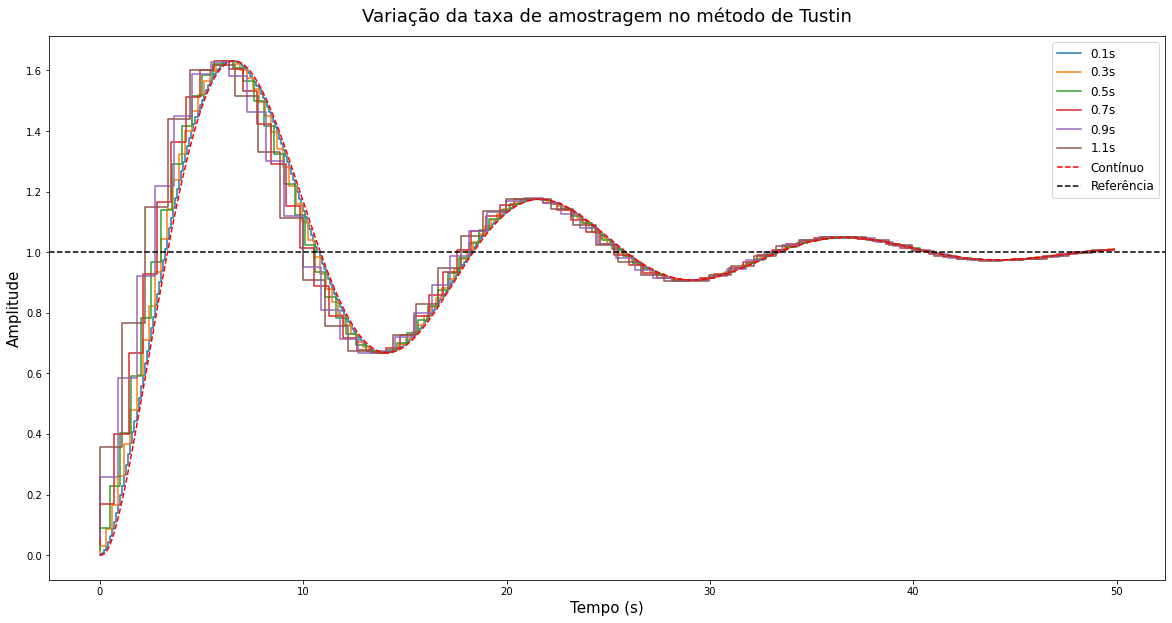

In [ ]:
plt.figure(figsize=(20,10))
t_con, y_con, aux = signal.lsim(sys_continuo, u, t)

for i in range(len(taxas_de_amostragem)):
  tx = taxas_de_amostragem[i]
  tf_atual = tf_list_tustin[i]

  plt.step(tf_atual[0], tf_atual[1], label=tx)

plt.plot(t_con, y_con, 'r--', label="Contínuo")
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Tempo (s)", fontsize=15)

plt.axhline(y = 1, color = 'black', linestyle = '--')

plt.title("Variação da taxa de amostragem no método de Tustin", fontsize=18, pad=15)
plt.legend(["0.1s", "0.3s", "0.5s", "0.7s", "0.9s", "1.1s", "Contínuo", "Referência"], prop={'size': 12}, loc = "best")
plt.show()

Comentário: Ao analisar o gráfico acima, é possível ver que quanto menos a taxa de amostragem aplicada mais o comportamento do sistema em tempo discreto se aproxima do comportamento do mesmo em tempo contínuo

# 3. Prove a estabilidade do sistema discreto encontrado na questão anterior utilizando o critério de Jury.

In [ ]:
def jury(coef):

  tabela = []
  tabela.append(coef)
  tabela.append(coef[::-1])
  n = len(coef)
  odd_line = 0
  linha = 2

  while n > 1:

    aux = []
    divisao = tabela[linha-2][n-1] / tabela[linha-2][0] # an/a0

    for k in range(n-1):
      # bk = ak − (an/a0)an−k
      bk = tabela[linha-2][k] - (divisao * tabela[linha-1][k])
      aux.append(round(bk, 5))

    tabela.append(aux)
    tabela.append(aux[::-1])

    linha += 2
    n -= 1

  return tabela

In [ ]:
def estabilidade_jury(tabela):

  for linha in range(0,len(tabela), 2):
    a0 = tabela[linha][0]

    if a0 <= 0:
      return "Existem raízes fora do círculo unitário: O sistema não é estável"

  return "Todas as raízes estão contidas no círculo unitário: O sistema é estável"

In [ ]:
print("Função de transferência discretizado pelo método de Tustin:\n",control.TransferFunction(num_tustin, den_tustin))

Função de transferência discretizado pelo método de Tustin:
 
0.0003382 s^4 + 0.0006981 s^3 + 6.545e-05 s^2 - 0.0006109 s - 0.0003163
-----------------------------------------------------------------------
            s^4 - 3.342 s^3 + 4.136 s^2 - 2.243 s + 0.4496



In [ ]:
coef_tustin = [1, -3.34, 4.136, -2.243, 0.4496]
tabela_tustin = jury(coef_tustin)
tabela_tustin

[[1, -3.34, 4.136, -2.243, 0.4496],
 [0.4496, -2.243, 4.136, -3.34, 1],
 [0.79786, -2.33155, 2.27645, -0.74134],
 [-0.74134, 2.27645, -2.33155, 0.79786],
 [0.10904, -0.21636, 0.11007],
 [0.11007, -0.21636, 0.10904],
 [-0.00207, 0.00204],
 [0.00204, -0.00207],
 [-6e-05],
 [-6e-05]]

In [ ]:
estabilidade_jury(tabela_tustin)

'Existem raízes fora do círculo unitário: O sistema não é estável'

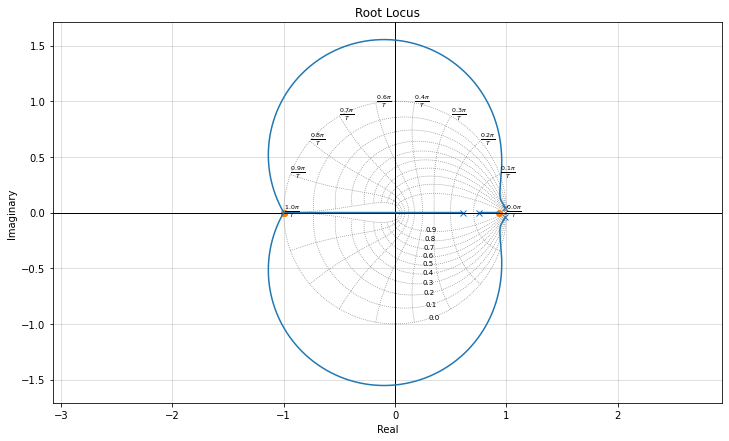

In [ ]:
plt.figure(figsize=(12, 7))

sys_cont = matlab.TransferFunction(num, den)
sys_disc = matlab.c2d(sys_cont, 0.1, 'bilinear')

rlocus = matlab.rlocus(sys_disc)
plt.grid(alpha = 0.5)
plt.show()

# 4. Implemente um controlador PID discreto de forma a melhorar o comportamento do sistema discretizado.

In [ ]:
def calculo_erro(point, out, e1, e2, e3):
  e3 = e2
  e2 = e1
  e1 = point - out

  return e1, e2, e3

def controlador_PID(e1, e2, e3, entrada):
  # valores escolhidos de forma arbitrária observando a resposta do sistema
  kp = 14.5
  ki = 12.3
  kd = 0.0000005

  u = entrada + (kp*(e1-e2)) + (ki*0.1*e1) + ((kd/0.1)*(e1-e2-e3))

  return u

# valores iniciais 
tempo = np.arange(0,70,0.1) 

entrada = np.zeros(len(tempo))
entrada[0]=1

discreto = signal.cont2discrete((num, den), 0.1, 'bilinear')

In [ ]:
def malha_fechada(sistema, entrada, tempo):
  e1, e2, e3 = 0, 0, 0
  instante = 0
  t_out, y_out = np.zeros(len(tempo)), np.zeros(len(tempo))

  while(instante!=len(tempo)-1):
    t_out, y_out = signal.dlsim(sistema, entrada, tempo)
    resposta = y_out[instante]

    e1, e2, e3 = calculo_erro(1, resposta, e1, e2, e3)

    entrada[instante+1] = controlador_PID(e1, e2, e3, resposta)

    instante+=1
  
  return t_out, y_out

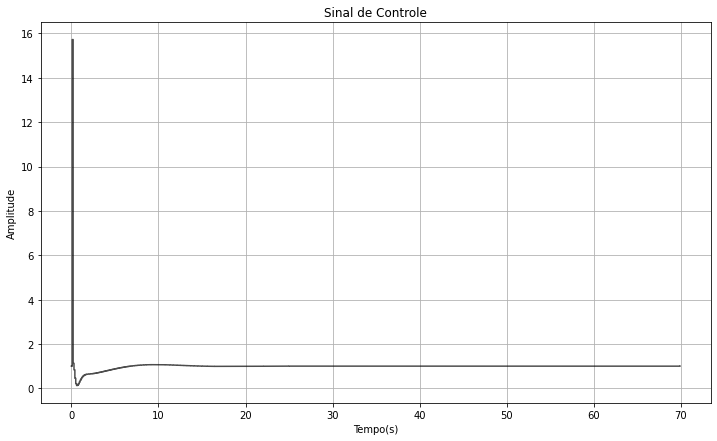

In [ ]:
t_out, y_out = malha_fechada(discreto, entrada, tempo)

plt.figure(figsize=(12, 7))
plt.step(t_out, entrada, 'k', alpha = 0.7 , where='post', linewidth = 1.5)
plt.title('Sinal de Controle')
plt.grid(0.5)
plt.xlabel('Tempo(s)')
plt.ylabel('Amplitude')
plt.show()

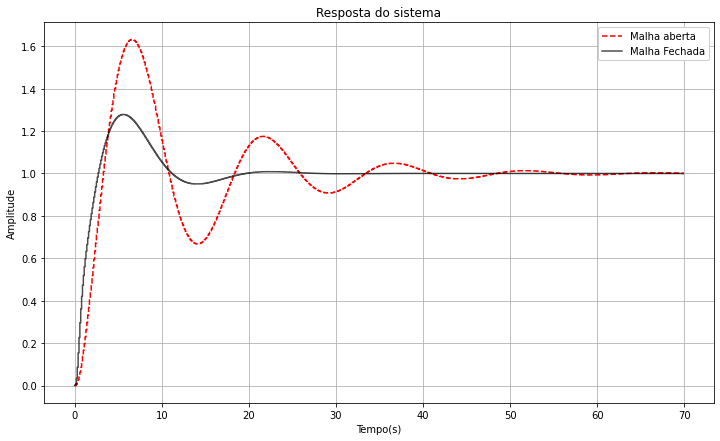

In [ ]:
tempo = np.arange(0,70,0.1)
entrada = np.full(len(tempo),1)

t_disc, y_disc = signal.dlsim(discreto, entrada, tempo)

plt.figure(figsize=(12, 7))
plt.step(t_disc, y_disc,'r--',where='post', label = 'Malha aberta', linewidth = 1.5)
plt.step(t_out, y_out, 'k', alpha = 0.7,where='post', label = 'Malha Fechada' , linewidth = 1.5)
plt.legend(loc='best', framealpha=1)
plt.title('Resposta do sistema')
plt.grid(0.5)
plt.xlabel('Tempo(s)')
plt.ylabel('Amplitude')
plt.show()

Comentário: Após a implementação do controlador PID no sistema discretizado pelo método de Tustin, é possível observar que o tempo para que o sistema alcance a referência é menor que antes tal como a ultrapassagem.

# 5. Implemente um controlador *Deadbeat* e compare com a resposta da questão 4. Comente sobre o desempenho dos controladores.

In [ ]:
# valores iniciais
tempo = np.arange(0,50, 0.1)
entrada = np.zeros(len(tempo))
erro = np.zeros(len(tempo))
erro[0]=1

In [ ]:
# Função de transferência G(z) para o sistema em malha aberta:
num = [0,0,0,3.75,2.5]
den = [1, 7.875, 15.25, 3.75, 2.5]
sys_discreto_tustin = signal.cont2discrete((num,den), 0.1, 'bilinear')

num_tustin = [ 0.0003382 , 0.0006981 ,  6.545e-05 , -0.0006109 , -0.0003163]
den_tustin = [ 1.        , -3.342 ,  4.136 , -2.243 , 0.4496]
sistema_DB = signal.TransferFunction(num_tustin, den_tustin, dt=0.1) 

# Função de transferência D(z) do controlador:
# invertendo G(z):
# num_DB = [ 1.        , -3.3416893  , 4.13572449, -2.24341395 , 0.44955329]
# den_DB = [ 3.38165832e-04 , 6.98148815e-04 , 6.54514514e-05 , -6.10880213e-04, -3.16348682e-04]

# multiplicando por 1/(z-1):
num_DB = [ 1.        , -3.3416893  , 4.13572449, -2.24341395 , 0.44955329]
den_DB = [0.0003382, 0.0003599, - 0.00063265, - 0.00067635,  0.0002946, 0.0003163]
controlador_DB = signal.TransferFunction(num_DB, den_DB, dt=0.1)

In [ ]:
def erro_DB(point, saida):
  return point - saida


def malha_fechada_DB(sistema, controlador, entrada, tempo, erro):
  saida_sistema = np.zeros(len(tempo))
  saida_controlador = np.zeros(len(tempo))
  t_saida = np.zeros(len(tempo))
  instante_t = 0
  
  while(instante_t != len(tempo)):
    t_saida, saida_controlador = signal.dlsim(controlador, erro, tempo)
    resposta = saida_controlador[instante_t]
    entrada[instante_t] = resposta

    t_saida, saida_sistema = signal.dlsim(sistema, entrada, tempo)
    resposta = saida_sistema[instante_t]

    erro[instante_t] = erro_DB(1, resposta)

    instante_t+=1

  return t_saida, saida_controlador, saida_sistema, erro

In [ ]:
t_saida, saida_controlador, saida_sistema, erro= malha_fechada_DB(sistema_DB, controlador_DB, entrada, tempo, erro)

In [ ]:
u = np.full(len(tempo), 1)
t_aberta, y_aberta = signal.dlsim(sys_discreto_tustin, u, tempo)

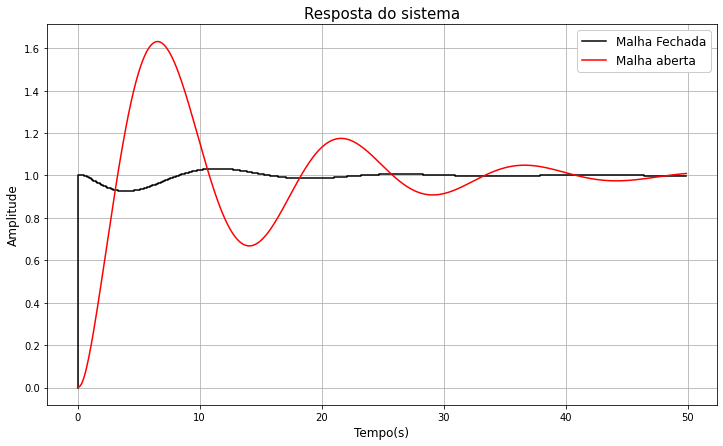

In [ ]:
plt.figure(figsize=(12,7))
plt.step(tempo, saida_sistema, color='black', label = 'Malha Fechada')
plt.plot(t_aberta, y_aberta, color='red', label = 'Malha aberta')
plt.legend(loc='best', framealpha=1, fontsize=12)
plt.title('Resposta do sistema', fontsize=15)
plt.grid(0.5)
plt.xlabel('Tempo(s)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.show()

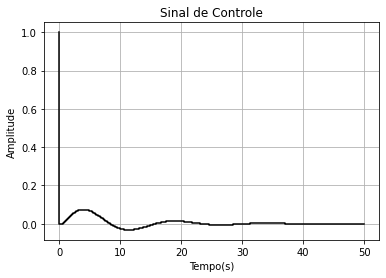

In [ ]:
plt.step(t_saida, erro, color = 'black')
plt.title('Sinal de Controle')
plt.grid(0.5)
plt.xlabel('Tempo(s)')
plt.ylabel('Amplitude')
plt.show()

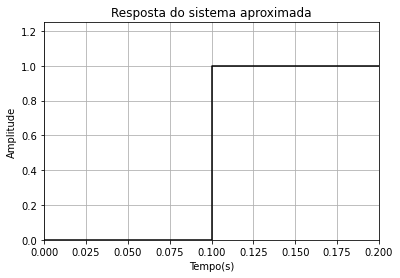

In [ ]:
plt.step(t_saida, saida_sistema, color = 'black')
plt.xlim(0, 0.2)
plt.ylim(0, 1.25)
plt.title('Resposta do sistema aproximada')
plt.grid(0.5)
plt.xlabel('Tempo(s)')
plt.ylabel('Amplitude')
plt.show()

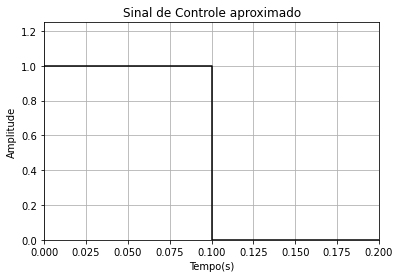

In [ ]:
plt.step(t_saida, erro, color = 'black')
plt.xlim(0, 0.2)
plt.ylim(0, 1.25)
plt.title('Sinal de Controle aproximado')
plt.grid(0.5)
plt.xlabel('Tempo(s)')
plt.ylabel('Amplitude')
plt.show()